In [8]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.transform import resize
import tarfile
import sys
sys.path.append("..")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations, layers, losses, optimizers, regularizers

2023-03-18 22:18:31.384192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def progress(iterable, every=1):
    for index, item in enumerate(iterable):
        if index % every == 0: print("*", end="")
        yield item
    print(".")

def read_images(arch_path, crop_x=80, crop_y=80, size_x=90, size_y=90):
    with tarfile.open(arch_path) as arch:
        for entry in arch.getmembers():
            if entry.isfile() and entry.name.endswith(".jpg"):
                image = plt.imread(arch.extractfile(entry))
                image = image[crop_x : -crop_x, crop_y : -crop_y, : ]
                image = resize(image, (size_x, size_y))
                yield image

In [10]:
# lfw_url = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
lfw_path = "lfw-deepfunneled.tgz"

# keras.utils.get_file(lfw_path, lfw_url, cache_dir=".", cache_subdir="")

# print("Extracting images: ", end="")
data = np.float32([ image for image in progress(read_images(lfw_path, size_x=36, size_y=36), every=200) ])

*******************************************************************.


Image shape : (36, 36, 3)
Total images: 13233


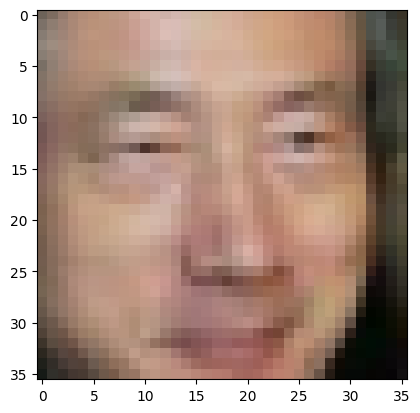

In [11]:
IMAGE_SHAPE = data.shape[1 : ]

print("Image shape :", IMAGE_SHAPE)
print("Total images:", len(data))
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

In [12]:
CODE_SIZE = 256

def generator():
    model = keras.Sequential()
    model.add(layers.Input(shape=(CODE_SIZE,), name='code'))
    model.add(layers.Dense(6*6*32, activation='elu'))
    model.add(layers.Reshape((6,6,32)))
    model.add(layers.Conv2DTranspose(128, kernel_size=5, activation='elu'))
    model.add(layers.Conv2DTranspose(128, kernel_size=3, activation='elu'))
    model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
    model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
    model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
    model.add(layers.Conv2DTranspose(3, kernel_size=3))
    
    return model


In [13]:
def discriminator():
    model = keras.Sequential()
    model.add(layers.Input(shape=IMAGE_SHAPE, name="image"))
    model.add(layers.Conv2D(32, kernel_size=3, activation='elu'))
    model.add(layers.Conv2D(32, kernel_size=5, activation='elu'))
    model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
    model.add(layers.Conv2D(128, kernel_size=5, activation='elu'))
    model.add(layers.Conv2D(128, kernel_size=3, activation='elu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2()))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model


In [14]:
keras.backend.clear_session()

In [15]:
gen = generator()
gen.summary()
print("Inputs :", gen.inputs)
print("Outputs:", gen.outputs)

assert gen.output_shape[1:] == IMAGE_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMAGE_SHAPE,gen.output_shape[1:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              296064    
                                                                 
 reshape (Reshape)           (None, 6, 6, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      102528    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 12, 12, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       73792     
 ranspose)                                                       
                                                        

2023-03-18 22:21:27.494763: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 22:21:27.710058: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 22:21:27.710124: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 22:21:27.711201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other oper

In [16]:
disc = discriminator()

disc.summary()
print("Inputs :", disc.inputs)
print("Outputs:", disc.outputs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 34, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         204928    
                                                      

2023-03-18 22:29:28.488486: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28.489622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28.518895: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28.519940: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28.539138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28.539957: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28.541246: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28.542018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28.548690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:28

# Training

In [17]:
def create_discriminator_loss(g, d):
    return lambda images, codes: -tf.math.reduce_mean(
        tf.math.log( d(images) ) + tf.math.log( 1 - d(g(codes)) )
    )

def create_generator_loss(g, d):
    return lambda codes: -tf.math.reduce_mean(tf.math.log( d(g(codes)) ))


In [18]:
disc_opt = optimizers.SGD(1e-3)
disc_loss = create_discriminator_loss(gen, disc)

gen_opt = optimizers.Adam(1e-4)
gen_loss = create_generator_loss(gen, disc)

2023-03-18 22:29:32.660998: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:32.661629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [19]:
def sample_codes(batch_size):
    return np.float32(np.random.normal(size=(batch_size, CODE_SIZE)))

def sample_images(batch_size):
    return data[ np.random.choice(len(data), size=batch_size) ]

def plot_images(nrow, ncol):
    preds = gen.predict(sample_codes(nrow * ncol))

    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(preds[i].clip(0., 1.), interpolation="none")
        plt.axis("off")
    plt.show()

def plot_probas(size):
    plt.hist(disc.predict(sample_images(size)),
        range=(0, 1), alpha=0.5, label="D(x)"
    )
    plt.hist(disc.predict(gen.predict(sample_codes(size))),
        range=(0, 1), alpha=0.5, label="D(G(x))"
    )
    plt.legend()
    plt.show()

    

### Training


In [20]:
epoch = tf.Variable(0)

ckpt = tf.train.Checkpoint(epoch=epoch, disc=disc, gen=gen, disc_opt=disc_opt, gen_opt=gen_opt)
manager = tf.train.CheckpointManager(ckpt, directory="./checkpoints", max_to_keep=10)

status = ckpt.restore(manager.latest_checkpoint)

2023-03-18 22:29:35.759812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:35.760786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:35.769827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 22:29:35.770515: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Epoch: 9900
1/1 [==============================] - 0s 12ms/step


2023-03-18 23:10:25.588553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.595219: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.599035: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.603406: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.607321: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.609822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


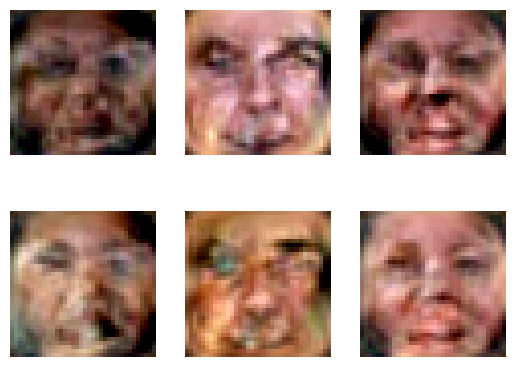

32/32 [==============================] - 0s 1ms/step


2023-03-18 23:10:25.704207: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.710738: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.716505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.720911: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.725024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.727601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-18 23:10:25.802189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.808590: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.812748: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.817042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.821013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.823483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.893520: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.899761: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


32/32 [==============================] - 0s 1ms/step


2023-03-18 23:10:25.905431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.910023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.914019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:25.916514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


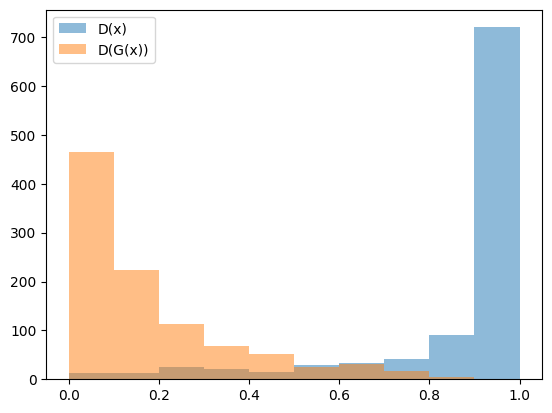

***************************************************************************************************.
CPU times: user 44min 11s, sys: 39.5 s, total: 44min 50s
Wall time: 41min 12s


In [21]:
%%time

for _ in progress(range(10000)): #30000 -> 10000
    codes = sample_codes(100)
    images = sample_images(100)

    for n in range(5):
        disc_opt.minimize(lambda: disc_loss(images, codes), disc.trainable_weights)

    gen_opt.minimize(lambda: gen_loss(codes), gen.trainable_weights)

    if epoch.numpy() % 100 == 0:
        display.clear_output(wait=True)

        print("Epoch:", epoch.numpy())
        plot_images(2, 3)
        plot_probas(1000)
        manager.save()

    epoch.assign_add(1)

Results after 10000 epochs:
4/4 [==============================] - 0s 11ms/step


2023-03-18 23:10:48.930078: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48.930846: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48.937167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48.937954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48.938694: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48.939296: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48.942476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48.946810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48.950811: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-18 23:10:48

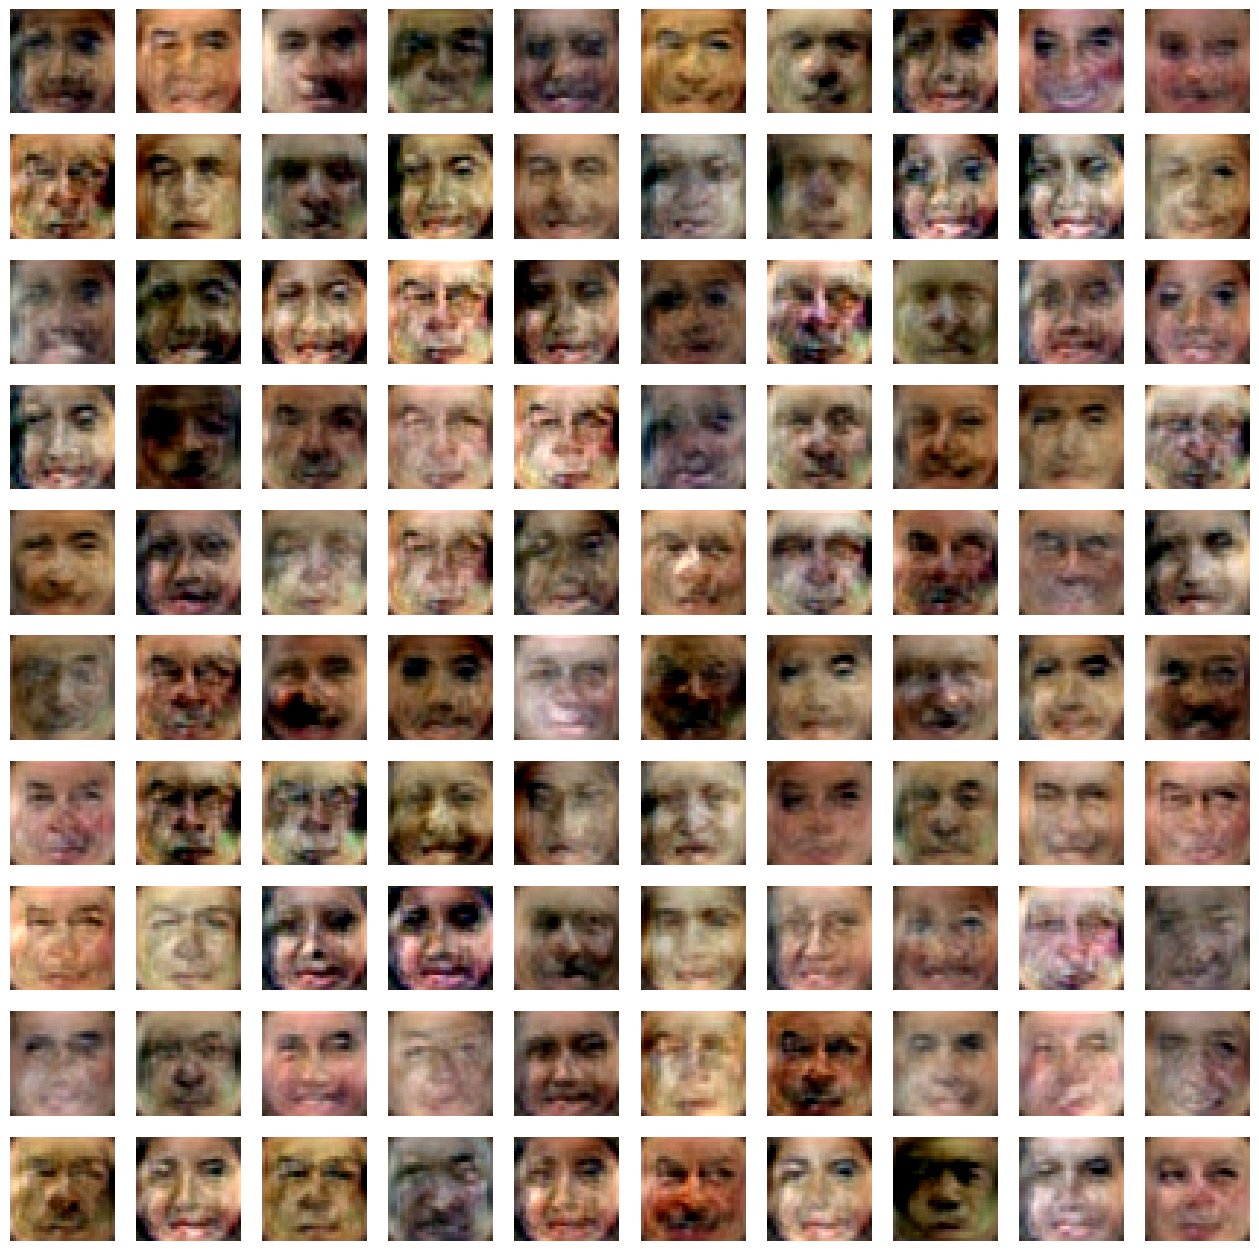

In [22]:
print("Results after", epoch.numpy(), "epochs:")
plt.figure(figsize=[16, 16])
plot_images(10, 10)